In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

class DepthwiseSeparableConv(nn.Module):
    """Depthwise separable convolution block."""
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, stride=stride, padding=padding, groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, 1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.relu(x)
        x = self.pointwise(x)
        x = self.bn(x)
        return x

class MobileNet(nn.Module):
    """MobileNet architecture for CIFAR-10."""
    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)

        # First Inverted Residual Block
        self.block1 = nn.Sequential(
            DepthwiseSeparableConv(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.block2 = nn.Sequential(
            DepthwiseSeparableConv(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True)
        )

        self.block3 = nn.Sequential(
            DepthwiseSeparableConv(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.block4 = nn.Sequential(
            DepthwiseSeparableConv(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x



In [ ]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_acc, val_acc = [], []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc.append(correct / total)

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_acc.append(correct / total)

        print(f'Epoch {epoch+1}/{num_epochs} - Train Acc: {train_acc[-1]:.3f} - Val Acc: {val_acc[-1]:.3f}')

    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('MobileNet - CIFAR-10 Training vs Validation Accuracy')
    plt.legend()
    plt.show()



In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10('data', train=True, download=True, transform=transform)
val_dataset = datasets.CIFAR10('data', train=False, download=True, transform=transform)
test_dataset = datasets.CIFAR10('data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = MobileNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10



100%|██████████| 170498071/170498071 [00:02<00:00, 74818607.67it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10 - Train Acc: 0.491 - Val Acc: 0.591
Epoch 2/10 - Train Acc: 0.631 - Val Acc: 0.651
Epoch 3/10 - Train Acc: 0.679 - Val Acc: 0.672
Epoch 4/10 - Train Acc: 0.708 - Val Acc: 0.669
Epoch 5/10 - Train Acc: 0.732 - Val Acc: 0.669
Epoch 6/10 - Train Acc: 0.746 - Val Acc: 0.721
Epoch 7/10 - Train Acc: 0.762 - Val Acc: 0.735
Epoch 8/10 - Train Acc: 0.775 - Val Acc: 0.715
Epoch 9/10 - Train Acc: 0.784 - Val Acc: 0.739
Epoch 10/10 - Train Acc: 0.794 - Val Acc: 0.759


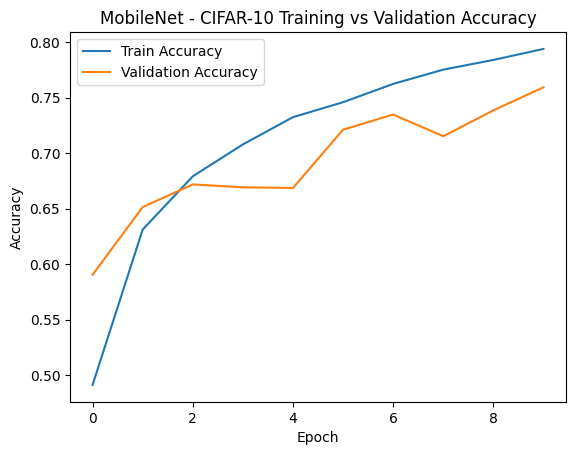

In [ ]:
# Train the model
train(model, train_loader, val_loader, criterion, optimizer, num_epochs)

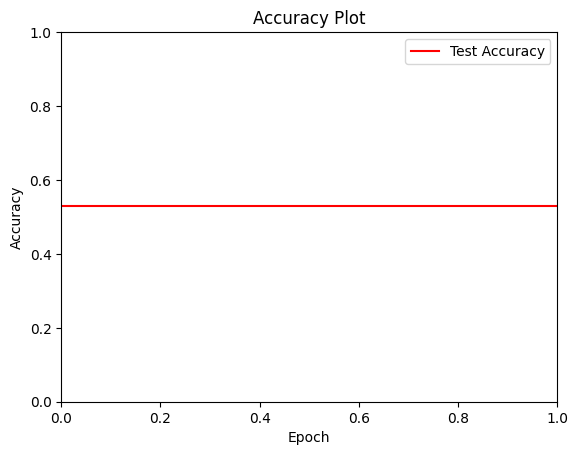

Test Accuracy: 0.530


In [ ]:
def calculate_accuracy(model, data_loader):
    #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #model.to(device)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            #images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Train the model and get training and validation accuracies
#train_acc, val_acc = train(model, train_loader, val_loader, criterion, optimizer, num_epochs)

# Calculate test accuracy
test_acc = calculate_accuracy(model, test_loader)

# Plotting
#plt.plot(train_acc, label='Train Accuracy')
#plt.plot(val_acc, label='Validation Accuracy')
plt.axhline(y=test_acc, color='r', linestyle='-', label='Test Accuracy')  # Plot test accuracy as a horizontal line
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Plot')
plt.legend()
plt.show()

print(f'Test Accuracy: {test_acc:.3f}')


In [ ]:
import numpy as np
import torch

def find_lr(model, train_loader, criterion, optimizer, init_value=1e-6, final_value=10., beta=0.98):
    num = len(train_loader) - 1
    mult = (final_value / init_value) ** (1/num)
    lr = init_value
    optimizer.param_groups[0]['lr'] = lr
    avg_loss = 0.
    best_loss = 0.
    batch_num = 0
    losses = []
    log_lrs = []
    for data in train_loader:
        batch_num += 1
        inputs, labels = data
        #inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        #Compute the smoothed loss
        avg_loss = beta * avg_loss + (1-beta) * loss.item()
        smoothed_loss = avg_loss / (1 - beta**batch_num)

        #Stop if the loss is exploding
        if batch_num > 1 and smoothed_loss > 4 * best_loss:
            return log_lrs, losses

        #Record the best loss
        if smoothed_loss < best_loss or batch_num==1:
            best_loss = smoothed_loss

        #Store the values
        losses.append(smoothed_loss)
        log_lrs.append(np.log10(lr))

        #Do the backward pass and optimize
        loss.backward()
        optimizer.step()

        #Update the lr for the next step
        lr *= mult
        optimizer.param_groups[0]['lr'] = lr

    return log_lrs, losses


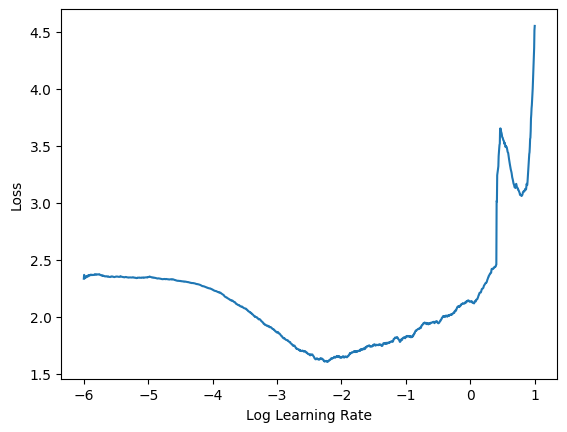

In [ ]:
model = MobileNet()#.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
log_lrs, losses = find_lr(model, train_loader, criterion, optimizer)

plt.plot(log_lrs, losses)
plt.xlabel('Log Learning Rate')
plt.ylabel('Loss')
plt.show()
